# Uvod #

U ovoj vježbi izgradit ćete model za predviđanje otkazivanja hotela s binarnim klasifikatorom.

In [1]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')


Prvo učitajte skup podataka *Hotel cancellations*.

In [2]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

hotel = pd.read_csv('./input/hotel.csv')

X = hotel.copy()
y = X.pop('is_canceled')

X['arrival_date_month'] = \
    X['arrival_date_month'].map(
        {'January':1, 'February': 2, 'March':3,
         'April':4, 'May':5, 'June':6, 'July':7,
         'August':8, 'September':9, 'October':10,
         'November':11, 'December':12}
    )

features_num = [
    "lead_time", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "is_repeated_guest", "previous_cancellations",
    "previous_bookings_not_canceled", "required_car_parking_spaces",
    "total_of_special_requests", "adr",
]
features_cat = [
    "hotel", "arrival_date_month", "meal",
    "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type", "customer_type",
]

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]

# 1) Definirajte model #

Model koji ćemo ovaj put koristiti imat će i batch normalization i dropout layer. Radi lakšeg čitanja razbili smo dijagram u blokove, ali možete ga definirati sloj po sloj kao i obično.

Definirajte model s arhitekturom danom ovim dijagramom:

<figure style="padding: 1em;">
<img src="figs/V04o59Z.png" width="400" alt="Diagram of network architecture: BatchNorm, Dense, BatchNorm, Dropout, Dense, BatchNorm, Dropout, Dense.">
<figcaption style="textalign: center; font-style: italic"><center>Dijagram binarnog klasifikatora.</center></figcaption>
</figure>


In [3]:
from tensorflow import keras
from tensorflow.keras import layers

# YOUR CODE HERE: define the model given in the diagram
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(units=256, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(units=256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(units=1, activation='sigmoid')
])


c:\Users\bruno\OneDrive\Radna površina\Reinforcement learning\reinforcement_learning\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# 2) Dodajte optimizator, loss i metriku #

Sada sastavite model s Adamovim optimizatorom i binarnim verzijama cross-entropy loss-a i metrike accuracy-a.

In [4]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

Na kraju, pokrenite ovu ćeliju da uvježbate model i pogledate krivulje učenja. Može trajati oko 60 do 70 epoha, što može potrajati minutu ili dvije.

Epoch 1/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - binary_accuracy: 0.7552 - loss: 0.5082 - val_binary_accuracy: 0.8093 - val_loss: 0.4357
Epoch 2/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.7958 - loss: 0.4292 - val_binary_accuracy: 0.8141 - val_loss: 0.4035
Epoch 3/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - binary_accuracy: 0.8108 - loss: 0.4090 - val_binary_accuracy: 0.8182 - val_loss: 0.3952
Epoch 4/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.8102 - loss: 0.4041 - val_binary_accuracy: 0.8222 - val_loss: 0.3887
Epoch 5/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.8119 - loss: 0.3992 - val_binary_accuracy: 0.8245 - val_loss: 0.3845
Epoch 6/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.8146 - loss: 0.3951 - val_binary_accuracy: 0.8253 - val_loss: 0.3826
Epoch 7/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.8208 - loss: 0.3883 - val_binary_accuracy: 0.8261 - val_loss: 0.3856

<Axes: title={'center': 'Accuracy'}>

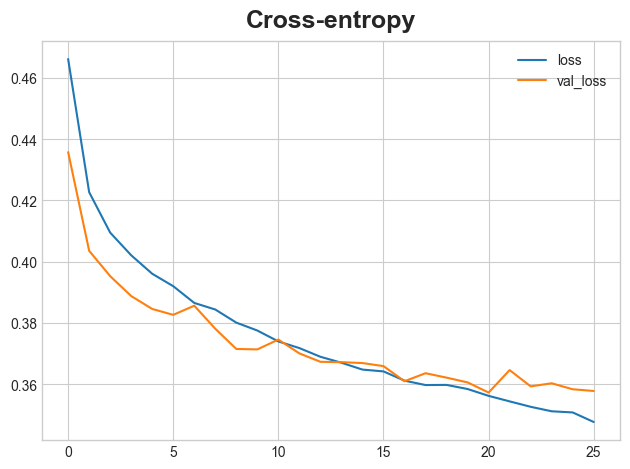

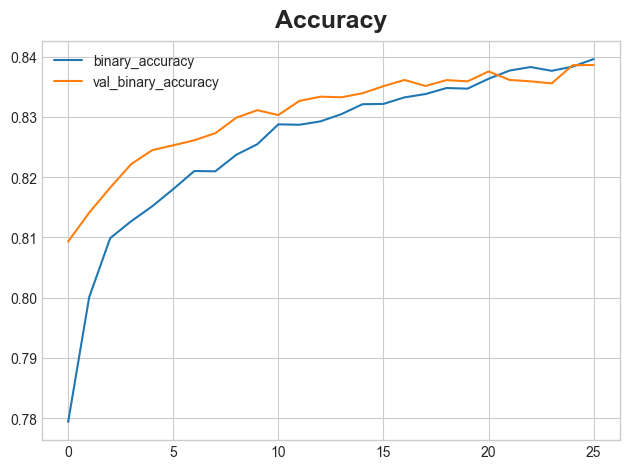

In [5]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

# 3) Train and verify #


Što mislite o krivuljama učenja? Izgleda li kao model underfit ili overfit? Je li cross-entropy loss bio dobra zamjena za accuracy?